# Generando un tren de pulsos de radar pulsado

Un radar pulsado es aquel capaz de medir tanto rango (distancia) como velocidad, haciendo uso de la transmisión de pulsos muy cortos de duración τ y un periodo de escucha mayor Τ para luego leer el reflejo del mismo en alguna superficie. La distancia al objetivo se determina por el tiempo de ida y vuelta de la señal (en el caso estacionario) generando un Δ$t$, lo que nos permite utilizar la siguiente fómula:
 ### <center> $R = \frac{\Delta t*c}{2}$            
  Donde $R$ es el rango y $c$ es la velocidad de propagación de la onda, que al ser electromagnética corresponde a la velocidad de la luz. Con esta información y midiendo el $\Delta t$, podemos calcular una estimación del rango.

In [1]:
import adi
import time
import sys
import timeit
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import threading
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
from scipy.fftpack import fftfreq
from scipy.linalg import bandwidth
fP1 = 930e6
fP2 = 962e6

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.35"
SamplingRate     = 6e6        # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 0          # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = fP1         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -30          # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 6e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = fP1      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize     = 2**20-1

In [3]:
Uri2              = "ip:192.168.1.34"
SamplingRate2     = 6e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback2         = 0          # 0=Disabled, 1=Digital, 2=RF

TxLOFreq2         = fP2         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten2          = -30         # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw2           = 6e6          # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq2         = fP1   # Carrier frequency of RX path [Hz]
GainControlModes2 = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain2   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw2           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize2     = 2**20-1

In [4]:
Uri3              = "ip:192.168.1.36"
SamplingRate3     = 6e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback3         = 0           # 0=Disabled, 1=Digital, 2=RF

TxLOFreq3         = fP2         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten3          = -30         # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw3           = 6e6          # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq3         = fP2      # Carrier frequency of RX path [Hz]
GainControlModes3 = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain3   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'
RxRfBw3           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz]
RxBufferSize3     = 2**20-1

Definimos variables como el PRI (pulse repetition interval) y su inversa, PRF (pulse repetition frequency). Por otro lado, determinamos la frecuencia de sampling y de transmisión dentro del pulso. El valor del PRI nos dará el rango máximo calculable por nuestro radar, ya que, nuestro pulso debe ser transmitido y recibido antes de volver a transmitir el segundo pulso. Es por esto que la máxima distancia calculable es:
  
$Max Range = \frac{c}{2}*PRI $.

En nuestro caso, la distancia máxima es de 150000 [m] o 150 [km] para un PRI de 0.001 [s] y una PRF de 1[kHz].

In [5]:
PRI = 0.001 #Se trata de un valor arbitrario, intervalo cada cuánto se repite el pulso (entre el inicio de un pulso y su antecesor)
PRF = 1/PRI #cantidad de pulsos por unidad de tiempo
potencia_señal = 1

pulses = 100 #cantidad de pulsos del radar

sample_f = SamplingRate
step = 1/SamplingRate #paso entre las muestras
f1 = 2e3
samples = pulses*int(PRI/step) # PRI/step cantidad de muestras que necesito para un PRI.


En esta porción de código calculamos la cantidad de $samples$ que vamos a utilizar, se obtiene de la división entre el intervalo de la repetición de pulsos y el paso entre las muestras, esto nos da la cantidad de muestras por pulso, luego, al multiplicarlo por la cantidad de pulsos del radar obtenemos la cantidad de muestras.

En las siguientes celdas generamos nuestra señal a transmitir ,nuestro vector de tiempo y se realiza la configuración de la SDR haciendo uso de la libreria adi. Modulamos el tren de pulsos con la siguiente función senoidal

\begin{equation}
    Tx_I = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx_Q = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx = Tx_I + jTx_Q = \sin(2* \pi * f_1 * t) + j * \sin(2* \pi * f_1 * t)
\end{equation}


In [6]:
t = np.linspace(0,(samples-1)*step,samples) #Genera el array de valores de tiempo (600.000 valores separados cada <step> unidades de tiempo)
pulse_length = 0.0000004#[s] => 0.5 duración del pulso en segundos
Tx_I = 20*np.sin(2*np.pi*f1*t) + 20
Tx_Q = 20*np.sin(2*np.pi*f1*t + np.pi/2) + 20
global zeros
zeros = np.zeros(len(t))  # arreglo completo
ones = np.ones(int(pulse_length*SamplingRate)) # señal continua de duracion pulse_length

for i in range(0,len(Tx_I),int(PRI*SamplingRate)):
      zeros[i:i+len(ones)] = ones #Cada un PRI, hacemos a la función zeros igual a 1 durante un tiempo <pulse_length> (es decir tenemos un tren de pulsos)
        
#zeros[:int(pulse_length*SamplingRate)] = zeros[:int(pulse_length*SamplingRate)] * 20
zerosOG = zeros

/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


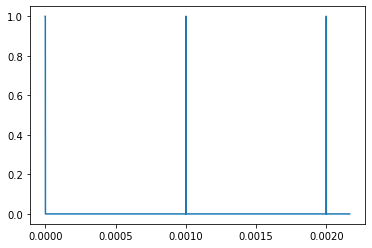

In [7]:
#Tx_I = Tx_I # parte real de la señal
#Tx_Q = Tx_Q #parte imaginaria
#Tx = Tx_I + 1j * Tx_Q #señal completa
Tx_I = Tx_I * zeros # parte real de la señal
Tx_Q = Tx_Q * zeros #parte imaginaria
Tx = zeros + 1j*zeros
plt.plot(t[:13000],Tx[:13000])

In [8]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = True
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

In [9]:
#-----------------------------------SDR Configurations-------------------------------
sdr2             = adi.Pluto(Uri2)
sdr2.sample_rate = SamplingRate2
sdr2.loopback    = Loopback2
#Tx:
sdr2.tx_lo                 = int(TxLOFreq2)
sdr2.tx_hardwaregain_chan0 = TxAtten2
sdr2.tx_rf_bandwidth       = int(TxRfBw2)
sdr2.tx_buffer_size        = samples
sdr2.tx_cyclic_buffer      = True
# Rx:
sdr2.rx_lo                   = int(RxLOFreq2)
sdr2.gain_control_mode_chan0 = GainControlModes2
sdr2.rx_rf_bandwidth         = int(RxRfBw2)
sdr2.rx_cyclic_buffer        = True
sdr2.rx_buffer_size          = RxBufferSize2
sdr2.rx_enabled_channels = [0]

In [10]:
#-----------------------------------SDR Configurations-------------------------------
sdr3             = adi.Pluto(Uri3)
sdr3.sample_rate = SamplingRate3
sdr3.loopback    = 2
#Tx:
sdr3.tx_lo                 = int(TxLOFreq3)
sdr3.tx_hardwaregain_chan0 = TxAtten3
sdr3.tx_rf_bandwidth       = int(TxRfBw3)
sdr3.tx_buffer_size        = samples
sdr3.tx_cyclic_buffer      = True
# Rx:
sdr3.rx_lo                   = int(RxLOFreq3)
sdr3.gain_control_mode_chan0 = GainControlModes3
sdr3.rx_rf_bandwidth         = int(RxRfBw3)
sdr3.rx_cyclic_buffer        = True
sdr3.rx_buffer_size          = RxBufferSize3
sdr3.rx_enabled_channels = [0]

Tramisión y Recepción

In [11]:
Loopback        = 0 
sdr.loopback    = Loopback
sdr.rx_destroy_buffer()
sdr.tx_destroy_buffer()
sdr2.tx_destroy_buffer()
global picture
global rxSignal
global rxSignalPic3
global rxSignalPic
global zeros
global zerosPic
global tim1
global tim2

# Función para la transmisión en un hilo
def transmitir():
    global tim1
    global tim2
    sdr.tx(Tx * ((2**15-1)))
    tim1 = time.time()
    time.sleep(0.0008)
    #sdr3.loopback = 2
    tim2 = time.time()
    print(((tim2-tim1)/PRI)%1)

# Función para la recepción en un hilo
def recibir1():
    global rxSignalPic
    rxSignalPic = sdr.rx() / ((2**15-1)) 

def recibir2():
    global rxSignalPic3
    rxSignalPic3 = sdr2.rx()/(2**15-1)

   
# Crea los hilos
thread_tx = threading.Thread(target=transmitir)
thread_rx2 = threading.Thread(target=recibir2)      
thread_rx1 = threading.Thread(target=recibir1)

thread_rx2.start()
thread_tx.start()
thread_rx1.start()
          
# Espera a que los hilos terminen
thread_tx.join()
thread_rx2.join()
thread_rx1.join()    
   


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/tljh/user/lib/python3.9/threading.py", line 973, in _bootstrap_inner
ERROR: Open unlocked: -16
    self.run()
  File "/opt/tljh/user/lib/python3.9/threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_14899/215414885.py", line 19, in transmitir
  File "/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/adi/rx_tx.py", line 515, in tx
    self._tx_init_channels()
  File "/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/adi/rx_tx.py", line 450, in _tx_init_channels
    self.__txbuf = iio.Buffer(
  File "/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/iio.py", line 1015, in __init__
    self._buffer = _create_buffer(device._device, samples_count, cyclic)
  File "/home/jupyter-user_comdig23_3/.local/lib/python3.9/site-packages/iio.py", line 56, in _check_null
    raise OSError(err, _strerror(err))
OSError: [Errno 16] Devi

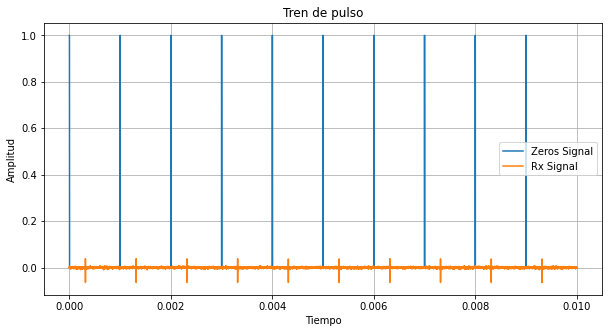

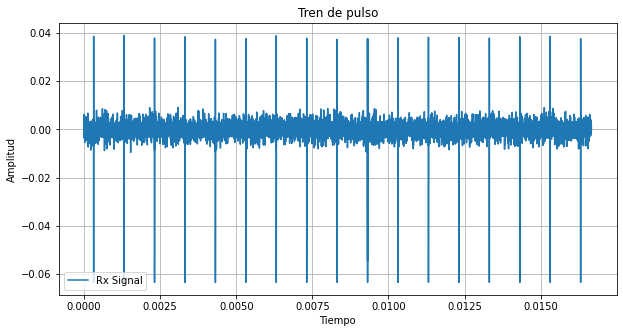

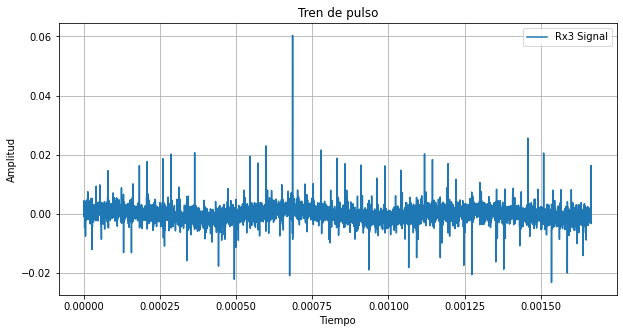

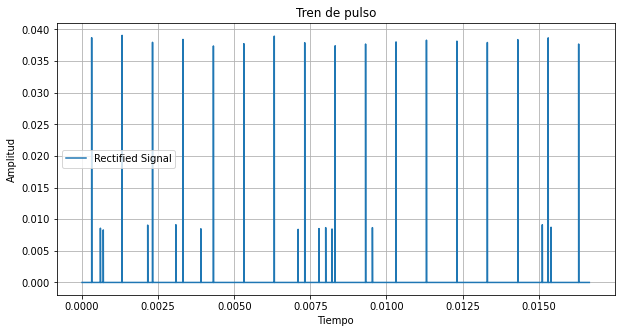

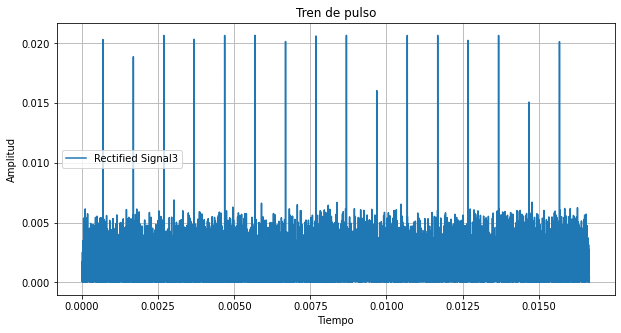

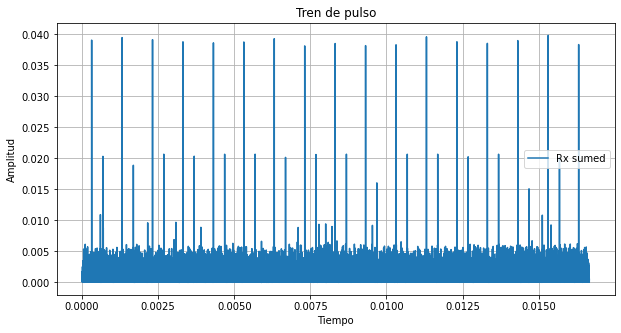

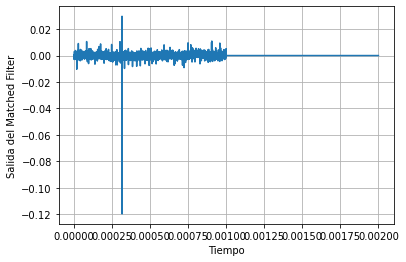

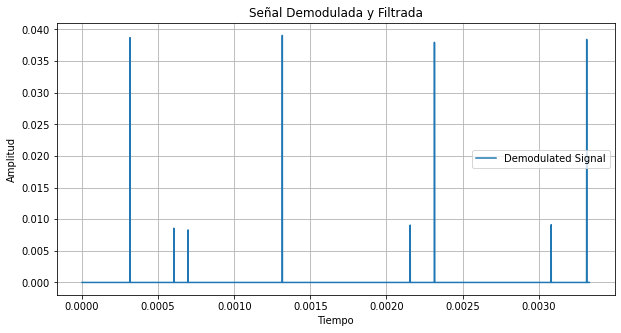

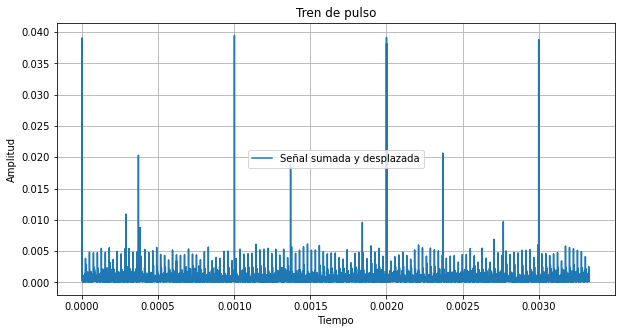

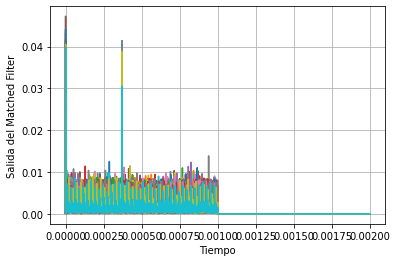

Tiempo delta estimado (MEDIANA): 0.00036933333333333333[s]
Tiempo delta estimado (MEDIA): 0.00018368499999999997[s]
Distancia estimada (MEDIANA): 55361.673910666665[m]
Distancia estimada (MEDIA): 27533.688823864995[m]


In [18]:
global rxSignal

zeros = zerosOG
def modificar_arreglo(arr):
    maximo_valor = max(arr)  # Calcula el máximo valor en el arreglo
    umbral = 0.2 * maximo_valor  # Establece el umbral al 60% del máximo

    # Modifica el arreglo, estableciendo a 0 los valores mayores al 60% del máximo
    nuevo_arreglo = [0 if valor < umbral else valor for valor in arr]

    return nuevo_arreglo

thread_rx2 = threading.Thread(target=recibir2)      
thread_rx1 = threading.Thread(target=recibir1)
thread_rx2.start()
thread_rx1.start()
thread_rx2.join()
thread_rx1.join()   


rxSignalPicOG = rxSignalPic
#rxSignalPic = rxSignalPic


#desplazas zeros timestamp2-timestamp1
rows, cols = (pulses, int(PRI*SamplingRate)) #cantidad de pulsos recibidos y cantidad de muestras en cada pulso

size = 15000
#rxSignalRectifed = np.maximum(rxSignalPic, 0)
rxSignalRectifed = np.abs(rxSignalPic)

rxSignal3Rectifed = np.abs(rxSignalPic3)

rxSignalRectifed = modificar_arreglo(rxSignalPic)

#rxSignal3Rectifed = modificar_arreglo(rxSignalPic3)
max1 = np.max(rxSignalRectifed)
max3 = np.max(rxSignal3Rectifed)
if(max3 > max1):
    rxSignal3Rectifed = rxSignal3Rectifed * (max1/(2*max3))
else:
    rxSignal3Rectifed = rxSignal3Rectifed/2
    

rxSignalSum = []
for j in range(len(rxSignalRectifed)):
    rxSignalSum.append(rxSignalRectifed[j] + rxSignal3Rectifed[j])

#rxSignalRectifed = modificar_arreglo(rxSignalRectifed)

#rxSignal3Rectifed = modificar_arreglo(rxSignal3Rectifed)

# Frecuencia de corte deseada en Hz
corte_deseado =100000# 100 kHz

# Frecuencia de muestreo de la señal
fs = SamplingRate # inserta tu frecuencia de muestreo aquí

# Calcula la frecuencia de corte normalizada
fc_normalizada = corte_deseado / (0.5 * fs)

rp = 3  # máxima ondulación en la banda de paso en dB
order = 4  # orden del filtro

# Diseña el filtro Chebyshev tipo I
b, a = signal.cheby1(order, rp, fc_normalizada, btype='low')

# Coeficientes del filtro pasa bajos
#b, a = signal.butter(4, fc_normalizada, btype='low')

# Aplica el filtro a la señal demodulada
demodulated_signal3_filtered = signal.lfilter(b, a, rxSignal3Rectifed)
demodulated_signal_filtered = signal.lfilter(b, a, rxSignalPic)

#demodulated_signal_filtered = signal.lfilter([1], [1, -0.9], rxSignalRectifed)


# Visualización de la señal recibida
plt.figure(figsize=(10, 5))
plt.plot(t[0:60000],zeros[0:60000], label='Zeros Signal')
plt.plot(t[0:60000],rxSignalPic[0:60000], label='Rx Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()


# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
plt.plot(t[0:100000], rxSignalPic[0:100000], label='Rx Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()


# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
plt.plot(t[0:10000], rxSignalPic3[0:10000], label='Rx3 Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()


# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[:100000], rxSignalRectifed[:100000], label='Rectified Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
#plt.plot(t[:size], zeros[:size], label='Zeros Signal')
plt.plot(t[:100000], rxSignal3Rectifed[:100000], label='Rectified Signal3')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

# Visualización de la señal recibida rectificada
plt.figure(figsize=(10, 5))
plt.plot(t[0:100000], rxSignalSum[0:100000], label='Rx sumed')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show()

#Matched filter used to maximize SNR ratio
def matched_filter(pulse,signal):
    #debo conjugar la señal o utilizar el pulso conjugado
    return np.convolve(pulse,signal,mode='full')

rows, cols = (pulses, int(PRI/step))
con =  [[0 for i in range(cols)] for j in range(rows)]

for i in range(rows):
       con[i] = matched_filter(zeros[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)],rxSignalPic[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)])    

plt.xlabel('Tiempo')
plt.ylabel('Salida del Matched Filter')
plt.grid(True)
plt.plot(t[:len(con[8])],con[3][:len(con[9])])
plt.show()       

index_max_i = 0
index_max_w = 0
max_con_j = []
max_con_w = []
max_i = 0
aux = 0
for j in range(len(con[0])):
    if((con[i][j] > max_i)):
        max_i = con[0][j]
        index_max_i = j - int(pulse_length * SamplingRate)
        
aux = index_max_i        
rxSignalSum = rxSignalSum[int(aux):]
rxSignalRectifed = np.concatenate([rxSignalRectifed, np.zeros(int(aux))]) 
# Visualización de la señal demodulada
plt.figure(figsize=(10, 5))
plt.plot(t[0:20000], rxSignalRectifed[0:20000], label='Demodulated Signal')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Señal Demodulada y Filtrada')
plt.grid(True)
plt.show() 
rows, cols = (pulses, int(PRI/step))
con =  [[0 for i in range(cols)] for j in range(rows)]
for i in range(rows):
       con[i] = matched_filter(zerosOG[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)],rxSignalSum[i*int(PRI*SamplingRate):i*int(PRI*SamplingRate)+int(PRI*SamplingRate)])


plt.figure(figsize=(10, 5))
plt.plot(t[0:20000], rxSignalSum[0:20000], label='Señal sumada y desplazada')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Amplitud')
plt.title('Tren de pulso')
plt.grid(True)
plt.show() 


plt.xlabel('Tiempo')
plt.ylabel('Salida del Matched Filter')
plt.grid(True)
for j in range(pulses):
    plt.plot(t[:len(con[8])],con[j][:len(con[9])])
#plt.plot(t[2000:3000],demodulated_signal_filtered[2000:3000])
plt.show()  
       
index_max_i = 0
index_max_w = 0
max_con_j = []
max_con_w = []
max_val_j = []
max_val_w = []
for i in range(rows):
    max_i = 0
    for j in range(len(con[i])):
        if((con[i][j] > max_i)):
            max_i = con[i][j]
            index_max_j = j - int(pulse_length * SamplingRate)
    max_j = 0        
    for w in range((index_max_j + int(2*pulse_length * SamplingRate)),len(con[i])): 
        if((con[i][w] > max_j)):
            max_j = con[i][w]
            index_max_w = w - int(pulse_length * SamplingRate)
    
    
    max_con_j.append(index_max_j)
    max_val_j.append(max_i)
    max_con_w.append(index_max_w)# Guardar el índice en lugar del tiempo
    max_val_w.append(max_j)
    
if (np.median(max_val_j) < np.median(max_val_w)):
    print(np.median(max_val_j))
    print(np.median(max_val_w))
    print("ERROR")
    sys.exit()
    
    
# Calcular el delta time estimado
stimation_delta_t1_mediana = np.median(max_con_j) / SamplingRate
stimation_delta_t2_mediana = np.median(max_con_w) / SamplingRate
stimation_delta_t_mediana = stimation_delta_t2_mediana - stimation_delta_t1_mediana

stimation_delta_t1_media = np.mean(max_con_j) / SamplingRate
stimation_delta_t2_media = np.mean(max_con_w) / SamplingRate
stimation_delta_t_media = stimation_delta_t2_media - stimation_delta_t1_media

print("Tiempo delta estimado (MEDIANA): " + str(stimation_delta_t_mediana) + "[s]")
print("Tiempo delta estimado (MEDIA): " + str(stimation_delta_t_media) + "[s]")

# Calcular el rango estimado
stimation_range_mediana = stimation_delta_t_mediana * 299792458 / 2
stimation_range_media = stimation_delta_t_media * 299792458 / 2
print("Distancia estimada (MEDIANA): " + str(stimation_range_mediana) + "[m]")
print("Distancia estimada (MEDIA): " + str(stimation_range_media) + "[m]")

